<img src='../IMG/TUD_logo.png' align='right' width='15%'></img>


Developed by: Thomas.Reimann@tu-dresden.de / Leonard.Grabow@mailbox.tu-dresden.de
<br>Last change: 2022 05 15

TODO:
- define 0 and N in the model plot
- align table to left


In [1]:
# Initialize librarys

import os
from scipy.special import erfc, erf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from ipywidgets import *
import flopy

ModuleNotFoundError: No module named 'scipy'

# 2D unconfined flow with defined head boundaries

In the [previous section](../HydroTeaching/MWW01/T02/MWW01_T02_1DGraben_unconfined_Aufgabe.ipynb) you learned how to formulate the problem of 1D, unconfined, steady-state flow with two given Dirichlet boundaries. We derived an analytical solution that describes the head over distance. In this section, we want to go one step further and expand the problem into the x-y plane.

Assume a rectangular model area in which each side has a defined head:



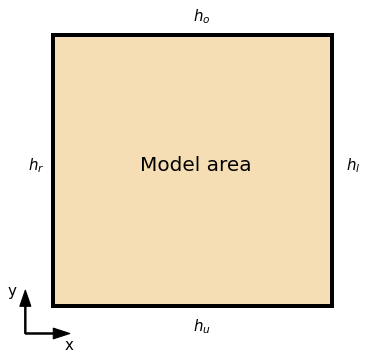

In [3]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)

plt.rcParams["hatch.linewidth"] = 4

ax.set_facecolor("wheat")
ax.set_xlim([1,2])
ax.set_ylim([1,2])
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(4)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.yaxis.set_ticks([])
ax.xaxis.set_ticks([])
plt.text(2.05,1.5,r"$h_l$", fontsize=15)
plt.text(0.91,1.5,r"$h_r$", fontsize=15)
plt.text(1.5,2.05,r"$h_o$", fontsize=15)
plt.text(1.5,0.91,r"$h_u$", fontsize=15)

plt.text(1.31,1.5,"Model area", fontsize=20)

plt.arrow(0.9,0.9, 0.1, 0, width=0.005, clip_on=False,head_width=0.04, color= "black")
plt.arrow(0.9,0.9, 0, 0.1, width=0.005, clip_on=False,head_width=0.04, color= "black")
plt.text(1.04,0.84,"x", fontsize=15)
plt.text(0.835,1.04,"y", fontsize=15)

ax.plot()
plt.show()

## Flow conditions within the model
Within the model area the following conditions exist:

| Condition | Mathematically &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; |
| -------- | -------- |
| Conversation of mass and volume | $\nabla^2 h(x,y,t)=0$ |
| Steady-State | $\frac{\partial h(x,y,t)}{\partial t}=0$ |




The combination of the two conditions leads to the formulation:

$\nabla^2 h(x,y) = \frac{\partial^2h}{\partial x^2} + \frac{\partial^2h}{\partial y^2} = 0$

## Boundaries

Flow at the boundaries comprises additional conditions through the defined head at each boundary. For example at the leftern boundary where $x=0$ the head must be equal to $h_l$. The same applies to all other boundaries. Mathematically this means:

$h(x=0, y) = h_l$

$h(x=L, y) = h_r$

$h(x, y=0) = h_u$

$h(x, y=L) = h_o$

# Numerical Model

In [4]:
# initial conditions for modell

name = "m2"
h_init = 15
Nlay = 1
N = 101
L = 10.0
H = 50.0


In [5]:



def modflow(h_l, h_r,h_o,h_u,k):
    # Create simulation object

    sim = flopy.mf6.MFSimulation(
        sim_name=name, exe_name="/home/grabow/modflow6/mf6", version="mf6", sim_ws="."
    )

    # Create temporal discretization object

    tdis = flopy.mf6.ModflowTdis(
        sim, pname="tdis", time_units="DAYS", nper=1, perioddata=[(1.0, 1, 1.0)]
    )


    # Create iterative model solution
    ims = flopy.mf6.ModflowIms(
        sim,
        pname="ims",
        complexity="SIMPLE",
        linear_acceleration="BICGSTAB",
    )

    # Create groundwater flow model

    model_nam_file = f"{name}.nam"
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=name,
        model_nam_file=model_nam_file,
        save_flows=True,
        newtonoptions="NEWTON UNDER_RELAXATION",
    )

    # Create discretization package

    bot = np.linspace(-H / Nlay, -H, Nlay)
    delrow = delcol = L / (N - 1)
    dis = flopy.mf6.ModflowGwfdis(
        gwf,
        nlay=Nlay,
        nrow=N,
        ncol=N,
        delr=delrow,
        delc=delcol,
        top=0.0,
        botm=bot,
    )

    # Create initial condition package

    start = h_init * np.ones((Nlay, N, N))
    ic = flopy.mf6.ModflowGwfic(gwf, pname="ic", strt=start)

    # Create node property flow package

    npf = flopy.mf6.ModflowGwfnpf(
        gwf,
        icelltype=1,
        k=k
    )
    
    # Create constant head

    chd_rec = []
    layer = 0
    for row_col in range(0, N):
        chd_rec.append(((layer, row_col, 0), h_l))
        chd_rec.append(((layer, row_col, N - 1), h_r))
        if row_col != 0 and row_col != N - 1:
            chd_rec.append(((layer, 0, row_col), h_o))
            chd_rec.append(((layer, N - 1, row_col), h_u))

    chd = flopy.mf6.ModflowGwfchd(
        gwf,
        stress_period_data=chd_rec,
    )
    
    # Create output control

    headfile = f"{name}.hds"
    head_filerecord = [headfile]
    budgetfile = f"{name}.cbb"
    budget_filerecord = [budgetfile]
    saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
    printrecord = [("HEAD", "LAST")]
    oc = flopy.mf6.ModflowGwfoc(
        gwf,
        saverecord=saverecord,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        printrecord=printrecord,
    )
    
    # Write the simulation files
    sim.write_simulation(silent=True)
    
    # Run the simulation
    success, buff = sim.run_simulation(silent=True)
    if not success:
        raise Exception("MODFLOW 6 did not terminate normally.")

    # Read and plot output data
    h = gwf.output.head().get_data(kstpkper=(0, 0))
    x = y = np.linspace(0, L, N)
    y = y[::-1]
    vmin, vmax = 0, 50
    contour_intervals = np.arange(0, 50, 1.0)

    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(111)

    ax.set_title("Hydraulic Head Distribution")
    modelmap = flopy.plot.PlotMapView(model=gwf, ax=ax)
    pa = modelmap.plot_array(h, vmin=vmin, vmax=vmax)
    quadmesh = modelmap.plot_bc("CHD")
    linecollection = modelmap.plot_grid(lw=0.5, color="0.5")
    contours = modelmap.contour_array(
        h,
        levels=contour_intervals,
        colors="black",
    )
    ax.clabel(contours, fmt="%2.1f")
    cb = plt.colorbar(pa, shrink=0.5, ax=ax)
    cb.set_label('Hydraulic Head (m)')#, rotation=270)
    plt.show()

In [6]:
# Start interactive plot

interact(modflow,
         h_l=widgets.FloatSlider(value=10,min=0, max=50, step=1,description='h,links:', disabled=False),
         h_r=widgets.FloatSlider(value=5,min=0, max=50, step=1,description='h,rechts:', disabled=False),
         h_o=widgets.FloatSlider(value=15,min=0, max=50, step=1,description='h,oben:', disabled=False),
         h_u=widgets.FloatSlider(value=5,min=0, max=50, step=1,description='h,unten:', disabled=False),
         k=widgets.FloatLogSlider(value=1E-4,min=-11, max=-1, step=0.5,description='k', disabled=False))


/home/grabow/anaconda3/envs/flopy/lib/python3.10/site-packages/ipykernel/pylab/backend_inline.py:10: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  warnings.warn(


interactive(children=(FloatSlider(value=10.0, description='h,links:', max=50.0, step=1.0), FloatSlider(value=5…

<function __main__.modflow(h_l, h_r, h_o, h_u, k)>

Have a look at the [listing file](./m2.lst)

<hr>
&copy; 2022 | Thomas Reimann
<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img style="float: right" alt="Creative Commons Lizenzvertrag" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a>